In [1]:
import numpy as np
import torch
import torch.nn as nn
import joblib
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FEATURES_PATH = "all_features.npy"
LABELS_PATH = "all_labels.npy"
RAW_DATA_PATH = "SensorDataSequences.npy"

SCALER_PATH = "autoregression_timeseries_data_scaler.save"

MODEL_PATH = "contextual_fidelity_model_pretrained_encoder.pth"

# 稀疏度
SPARSITY_RATIO = 0.8
SEQUENCE_LENGTH = 4            # 累积x个特征后进行一次推理

### 稀疏化函数定义

In [2]:
def create_sparse_data(data_array, sparsity_ratio):
    print("Sparsifying data...")
    sparse_array = data_array.copy()
    num_samples = sparse_array.shape[0]
    num_to_zero_out = int(num_samples * sparsity_ratio)
    indices_to_zero = np.random.choice(np.arange(num_samples), size=num_to_zero_out, replace=False)
    sparse_array[indices_to_zero] = 0
    print(f"Sparsification complete. {num_to_zero_out}/{num_samples} samples zeroed.")
    return sparse_array

### 数据加载

In [4]:
features = np.load(FEATURES_PATH)
labels = np.load(LABELS_PATH)

# 从文件中加载原始数据
raw_data = np.load(RAW_DATA_PATH)

# 归一化
print("\nApplying scaler to raw sensor data sequences...")
scaler = joblib.load(SCALER_PATH)

scaled_raw_data = []
for i in range(raw_data.shape[0]):
    scaled_sequence = scaler.transform(raw_data[i])
    scaled_raw_data.append(scaled_sequence)

print("Finished applying scaler to raw sensor data sequences.")

scaled_raw_data = np.array(scaled_raw_data)

# 稀疏化原始数据
sparse_raw_data = create_sparse_data(scaled_raw_data, SPARSITY_RATIO)

# 按 SEQUENCE_LENGTH 划分序列
def create_sequences(data_array, sequence_length):
    sequences = []
    num_samples = data_array.shape[0]
    for start_idx in range(0, num_samples - sequence_length + 1, sequence_length):
        end_idx = start_idx + sequence_length
        sequence = data_array[start_idx:end_idx]
        sequences.append(sequence)
    return np.array(sequences)

sparse_raw_data_sequences = create_sequences(sparse_raw_data, SEQUENCE_LENGTH)
features_sequences = create_sequences(features, SEQUENCE_LENGTH)
labels_sequences = create_sequences(labels, SEQUENCE_LENGTH)
print(f"Sparse raw data sequences shape: {sparse_raw_data_sequences.shape}")
print(f"Sparse features_sequences shape: {features_sequences.shape}")


Applying scaler to raw sensor data sequences...
Finished applying scaler to raw sensor data sequences.
Sparsifying data...
Sparsification complete. 7592/9491 samples zeroed.
Sparse raw data sequences shape: (2372, 4, 200, 11)
Sparse features_sequences shape: (2372, 4, 64)


### 模型定义

In [5]:
class TimeDistributedEncoder(nn.Module):
    def __init__(self, module):
        super(TimeDistributedEncoder, self).__init__()
        self.module = module

    def forward(self, x):
        batch_size, time_steps, seq_len, n_features = x.size()

        x_reshape = x.contiguous().view(batch_size * time_steps, seq_len, n_features)
        hidden, _ = self.module(x_reshape)
        output_features = hidden[-1]
        y = output_features.view(batch_size, time_steps, -1)
        
        return y
    
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query_layer = nn.Linear(query_dim, hidden_dim)
        self.key_layer = nn.Linear(key_dim, hidden_dim)
        self.value_layer = nn.Linear(key_dim, hidden_dim)
        self.scale = hidden_dim ** -0.5

    def forward(self, query, key, value):
        Q = self.query_layer(query)
        K = self.key_layer(key)
        V = self.value_layer(value)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        context_vector = torch.matmul(attention_weights, V)
        return context_vector


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        outputs, (hidden, cell) = self.lstm(x)
        # 返回最终的 hidden 和 cell 状态
        return hidden, cell


class ContextualFidelityModel(nn.Module):
    def __init__(self, lfs_feature_dim, lstm_hidden_dim, hfs_feature_dim, num_classes=1):
        super(ContextualFidelityModel, self).__init__()

        hfs_encoder = Encoder(input_dim=11, hidden_dim=hfs_feature_dim, n_layers=2, dropout=0.1)
        self.hfs_processor = TimeDistributedEncoder(hfs_encoder)

        self.lfs_processor = nn.LSTM(
            input_size=lfs_feature_dim, # 将接收64维特征
            hidden_size=lstm_hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )

        self.cross_attention = CrossAttention(
            query_dim=lstm_hidden_dim,
            key_dim=hfs_feature_dim, # 维度变为64
            hidden_dim=lstm_hidden_dim
        )
        
        self.post_fusion_processor = nn.LSTM(
            input_size=lstm_hidden_dim * 2, # Concatenated input
            hidden_size=lstm_hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, feature_sequence, imputed_raw_sequence):
        lfs_output, _ = self.lfs_processor(feature_sequence) # -> (B, 60, lstm_hidden_dim)
        hfs_output = self.hfs_processor(imputed_raw_sequence) # -> (B, 60, raw_cnn_output_dim)
        attention_context = self.cross_attention(
            query=lfs_output, 
            key=hfs_output, 
            value=hfs_output
        ) # -> (B, 60, lstm_hidden_dim)

        combined_features = torch.cat([lfs_output, attention_context], dim=-1)

        final_sequence, (h_n, _) = self.post_fusion_processor(combined_features)
        
        last_step_output = final_sequence[:, -1, :]
        logits = self.classifier(last_step_output)
        state_feature = h_n.squeeze(0) # -> (B, lstm_hidden_dim)

        return logits, state_feature

### 模型加载函数定义

In [6]:
# --- 模型加载 ---
def load_model(model_path):
    """加载训练好的模型并设置为评估模式"""
    print(f"Loading model from {model_path}...")
    
    # --- 模型超参数 (需要和训练时保持一致) ---
    LFS_FEATURE_DIM = 64
    HFS_FEATURE_DIM = 64 
    LSTM_HIDDEN_DIM = 256
    NUM_CLASSES = 1
    
    model = ContextualFidelityModel(
        lfs_feature_dim=LFS_FEATURE_DIM, 
        lstm_hidden_dim=LSTM_HIDDEN_DIM, 
        hfs_feature_dim=HFS_FEATURE_DIM, 
        num_classes=NUM_CLASSES
    )

    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}. Please train and save the model first.")
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")

    model.eval() # 设置为评估模式
    print("Model loaded successfully.")
    return model

### 主运行代码

In [7]:
feature_sequence = []
label_sequence = []

total_predictions = 0
correct_predictions = 0

save_counter = 0

list_index = 0

# 创建一个保存参数的列表
param_rows = []

model = load_model(MODEL_PATH)

while list_index < len(features_sequences):
    # 1. 累积一个序列长度的特征
    feature_sequence = features_sequences[list_index]
    label_sequence = labels_sequences[list_index]

    raw_data_array = sparse_raw_data_sequences[list_index]
    zero_vectors_count = np.sum(np.all(raw_data_array == 0, axis=(1, 2)))

    list_index += 1

    # 3. 准备模型输入
    feature_tensor = torch.tensor(np.array(feature_sequence), dtype=torch.float32).unsqueeze(0) # (1, 4, 6400)
    raw_data_tensor = torch.tensor(raw_data_array, dtype=torch.float32).unsqueeze(0) # (1, 4, 200, 11)
    
    # 4. 模型推理
    with torch.no_grad():
        logits, _ = model(feature_tensor, raw_data_tensor)
        
    prediction_prob = torch.sigmoid(logits).item()
    prediction = 1 if prediction_prob > 0.5 else 0
    
    # 5. 判断结果
    # 标签对应序列中的最后一个
    true_label = label_sequence[-1]
    
    total_predictions += 1
    is_correct = (prediction == true_label)
    if is_correct:
        correct_predictions += 1

    # 保存参数到DataFrame
    param_rows.append({
        "Zero_Vectors_Ratio": zero_vectors_count / raw_data_array.shape[0],
        "Probability": prediction_prob,
        "Predict_Label": prediction,
        "True_Label": true_label,
        "Result": 1 if is_correct else 0
    })

    # 6. 清空列表，为下一个序列做准备
    feature_sequence = []
    label_sequence = []

Loading model from contextual_fidelity_model_pretrained_encoder.pth...
Model loaded successfully.


### 绘图

  - Cumulative Accuracy: 91.82% (2178/2372)


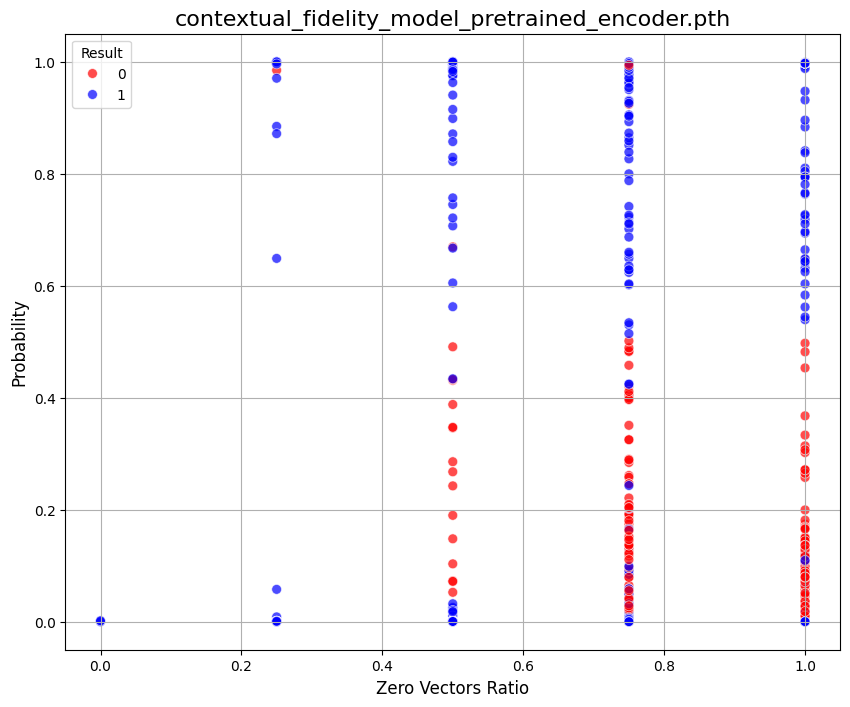

In [8]:
current_accuracy = (correct_predictions / total_predictions) * 100
print(f"  - Cumulative Accuracy: {current_accuracy:.2f}% ({correct_predictions}/{total_predictions})")

df = pd.DataFrame(param_rows)

color_map = {0: 'red', 1: 'blue'}

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Zero_Vectors_Ratio', y='Probability', hue='Result', palette=color_map, alpha=0.7, s=50)

# 添加标题和标签
plt.title(f'{MODEL_PATH}', fontsize=16)
plt.xlabel('Zero Vectors Ratio', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(True)
plt.legend(title='Result')

# 展示图表
plt.show()

### 数据分析

In [9]:
unique_numbers_list = pd.to_numeric(df['Zero_Vectors_Ratio'], errors='coerce').dropna().unique().tolist()


grouped_stats = df[df['Zero_Vectors_Ratio'].isin(unique_numbers_list)] \
    .groupby('Zero_Vectors_Ratio')['Result'] \
    .agg(
        total_count = 'size',  # 指标1: 分组总条数
        result_0_proportion = lambda x: (x == 0).mean() # 指标3: Result为0的占比
    )

# 3. 计算每个目标数字在总数据中的占比
total_proportions = df['Zero_Vectors_Ratio'].value_counts(normalize=True)
total_proportions_for_targets = total_proportions.loc[unique_numbers_list]

# 4. 将总体占比数据合并到主 DataFrame 中
final_summary_df = grouped_stats

final_summary_df['total_count'] = final_summary_df['total_count'].astype(int)

# (可选) 再次进行格式化
formatted_df = final_summary_df.copy()
formatted_df['result_0_proportion'] = formatted_df['result_0_proportion'].map('{:.2%}'.format)

print("格式化为百分比的结果:")
# 调整列的顺序以便阅读
print(formatted_df[['result_0_proportion', 'total_count']])

格式化为百分比的结果:
                   result_0_proportion  total_count
Zero_Vectors_Ratio                                 
0.00                             0.00%            3
0.25                             1.54%           65
0.50                             4.21%          380
0.75                             7.73%          932
1.00                            10.58%          992


### 保存到CSV文件

In [ ]:
# df.to_csv("simulation_results.csv", index=False)